In [1]:
%cd src
from unet_model import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


/content/src


In [2]:
# Load and preprocess data
img_tensor = (torch.tensor(np.load("before-image-1000.npy").astype(np.float32), dtype=torch.float32))/255.0
act_tensor = torch.tensor(np.load("actions-1000.npy"), dtype=torch.float32)
loc_tensor = torch.tensor(np.load("after-object-location-1000.npy"), dtype=torch.float32)
after_img_tensor = (torch.tensor(np.load("after-image-1000.npy").astype(np.float32), dtype=torch.float32))/255.0

In [3]:
def rgb_to_grayscale_luminance(image):
    # Apply the luminance formula: Y = 0.299*R + 0.587*G + 0.114*B
    grayscale_image = 0.299 * image[:, 0, :, :] + 0.587 * image[:, 1, :, :] + 0.114 * image[:, 2, :, :]
    return grayscale_image.unsqueeze(1)  # Add a channel dimension for grayscale


In [4]:
# Convert to grayscale and split data
img = rgb_to_grayscale_luminance(img_tensor)
after_img = rgb_to_grayscale_luminance(after_img_tensor)
img_train = img[0:800]
img_test = img[800:1000]
act_train = act_tensor[0:800]
act_test = act_tensor[800:1000]
loc_train = loc_tensor[0:800]
loc_test = loc_tensor[800:1000]
after_img_train = after_img[0:800]
after_img_test = after_img[800:1000]

In [5]:
# Initialize network and training components
net = UNet(1, 1)
criterion = nn.HuberLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(gamma=0.9999, optimizer=optimizer)


In [6]:
# Training settings
num_epochs = 300
accumulation_steps = 8
running_loss = 0.0

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class RobotDataset(Dataset):
    def __init__(self, before_images, actions, after_images, transform=None):
        self.before_images = before_images
        self.actions = actions
        self.after_images = after_images
        self.transform = transform

    def __len__(self):
        return len(self.before_images)

    def __getitem__(self, idx):
        before_img = self.before_images[idx]
        action = self.actions[idx]
        after_img = self.after_images[idx]

        # Convert action to one-hot
        action_onehot = torch.nn.functional.one_hot(action.to(torch.int64), num_classes=4).float()

        if self.transform:
            before_img = self.transform(before_img)
            after_img = self.transform(after_img)

        return before_img, action_onehot, after_img

In [8]:
def get_data_loaders(batch_size=16, num_workers=0):
    # Load data
    img_tensor = (torch.tensor(np.load("before-image-1000.npy").astype(np.float32), dtype=torch.float32))/255.0
    act_tensor = torch.tensor(np.load("actions-1000.npy"), dtype=torch.float32)
    after_img_tensor = (torch.tensor(np.load("after-image-1000.npy").astype(np.float32), dtype=torch.float32))/255.0

    def rgb_to_grayscale_luminance(image):
        grayscale_image = 0.299 * image[:, 0, :, :] + 0.587 * image[:, 1, :, :] + 0.114 * image[:, 2, :, :]
        return grayscale_image.unsqueeze(1)

    # Convert to grayscale
    img = rgb_to_grayscale_luminance(img_tensor)
    after_img = rgb_to_grayscale_luminance(after_img_tensor)

    # Split into train and test sets
    train_size = 800

    # Create datasets
    train_dataset = RobotDataset(
        before_images=img[:train_size],
        actions=act_tensor[:train_size],
        after_images=after_img[:train_size]
    )

    test_dataset = RobotDataset(
        before_images=img[train_size:],
        actions=act_tensor[train_size:],
        after_images=after_img[train_size:]
    )

    # Create data loaders with modified settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,  # Set to 0 for debugging
        pin_memory=True,
        persistent_workers=False,  # Disable persistent workers
        drop_last=True  # Drop incomplete last batch
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,  # Set to 0 for debugging
        pin_memory=True,
        persistent_workers=False,  # Disable persistent workers
        drop_last=True  # Drop incomplete last batch
    )

    return train_loader, test_loader

In [9]:
# Get dataloaders with modified settings
train_loader, test_loader = get_data_loaders(batch_size=128, num_workers=0)  # Set num_workers to 0 to debug

net = net.cuda()
# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0

    try:
        for i, (inputs, actions, targets) in enumerate(train_loader):

            # Forward pass
            outputs = net(inputs.cuda(), actions.cuda())
            loss = criterion(outputs, targets.cuda())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()

    except Exception as e:
        print(f"Error during training: {str(e)}")
        print("Input shapes:", inputs.shape if inputs is not None else None)
        print("Action shapes:", actions.shape if actions is not None else None)
        print("Target shapes:", targets.shape if targets is not None else None)
        raise e
    scheduler.step()

    print(f'[{epoch + 1}] loss: {running_loss / 10:.8f}')


print('Finished Training')

[1] loss: 0.16869649
[2] loss: 0.02104063
[3] loss: 0.01594229
[4] loss: 0.00999488
[5] loss: 0.00773226
[6] loss: 0.00776990
[7] loss: 0.00729841
[8] loss: 0.00631263
[9] loss: 0.00610497
[10] loss: 0.00603785
[11] loss: 0.00598551
[12] loss: 0.00573043
[13] loss: 0.00559005
[14] loss: 0.00555156
[15] loss: 0.00524764
[16] loss: 0.00539051
[17] loss: 0.00527902
[18] loss: 0.00524911
[19] loss: 0.00493914
[20] loss: 0.00473677
[21] loss: 0.00457532
[22] loss: 0.00470176
[23] loss: 0.00460569
[24] loss: 0.00448112
[25] loss: 0.00445660
[26] loss: 0.00410554
[27] loss: 0.00380177
[28] loss: 0.00356338
[29] loss: 0.00330497
[30] loss: 0.00328789
[31] loss: 0.00316679
[32] loss: 0.00322455
[33] loss: 0.00303368
[34] loss: 0.00307542
[35] loss: 0.00291478
[36] loss: 0.00270910
[37] loss: 0.00264849
[38] loss: 0.00258003
[39] loss: 0.00233724
[40] loss: 0.00221969
[41] loss: 0.00222669
[42] loss: 0.00230007
[43] loss: 0.00209048
[44] loss: 0.00210610
[45] loss: 0.00230272
[46] loss: 0.002468

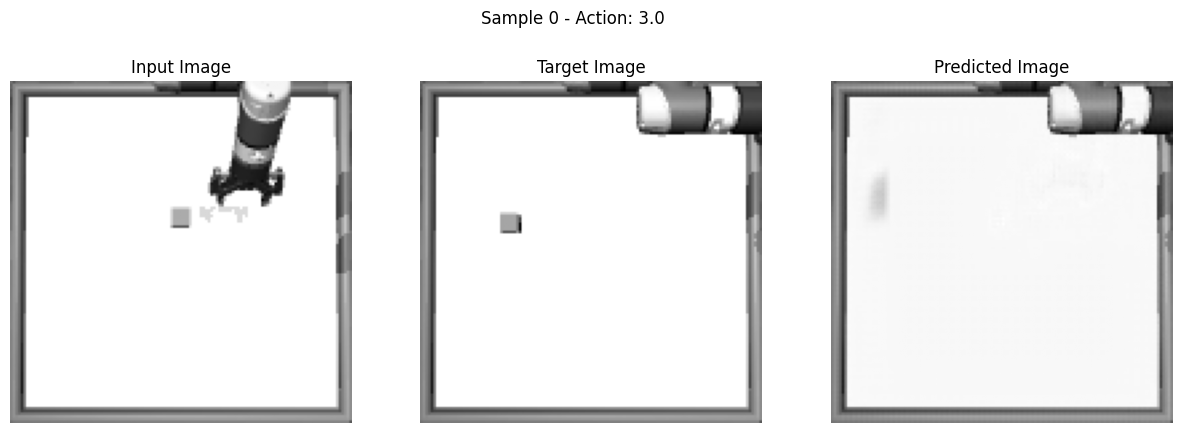

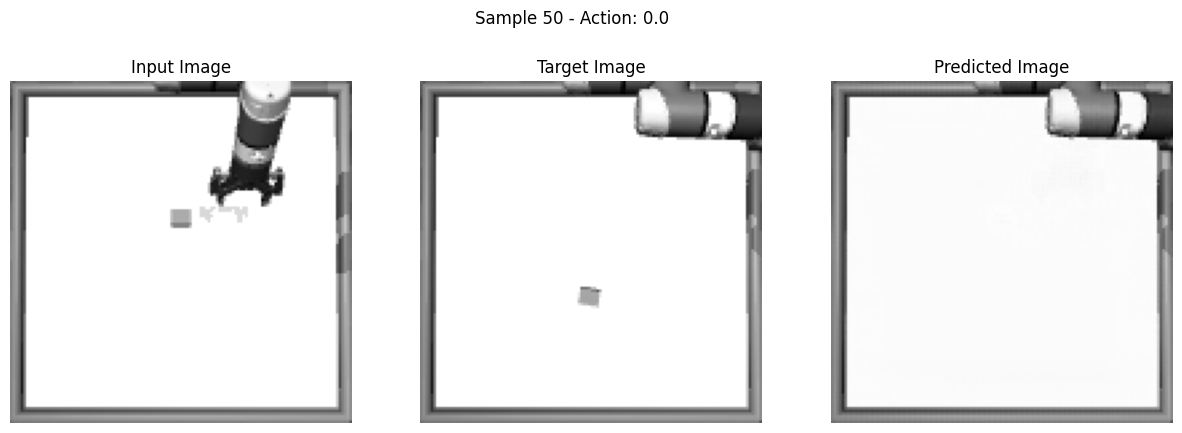

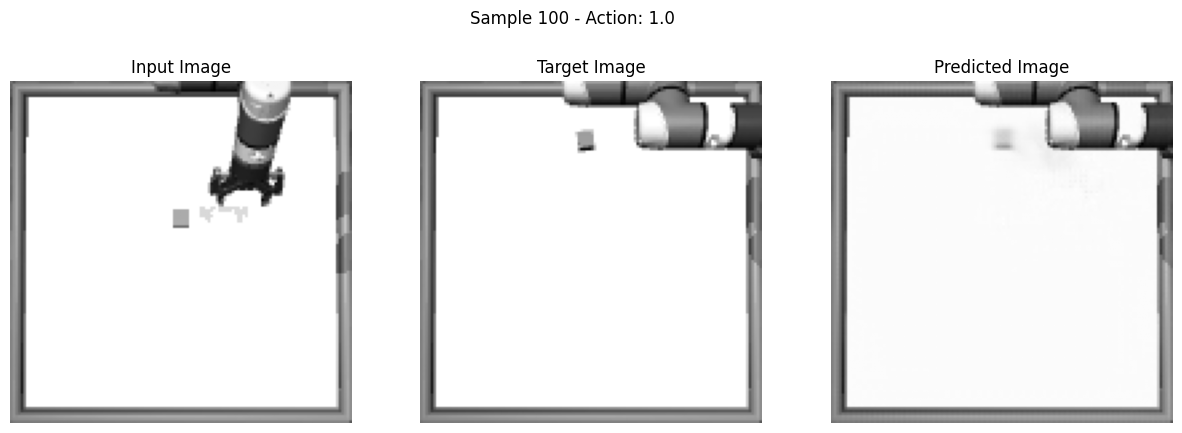

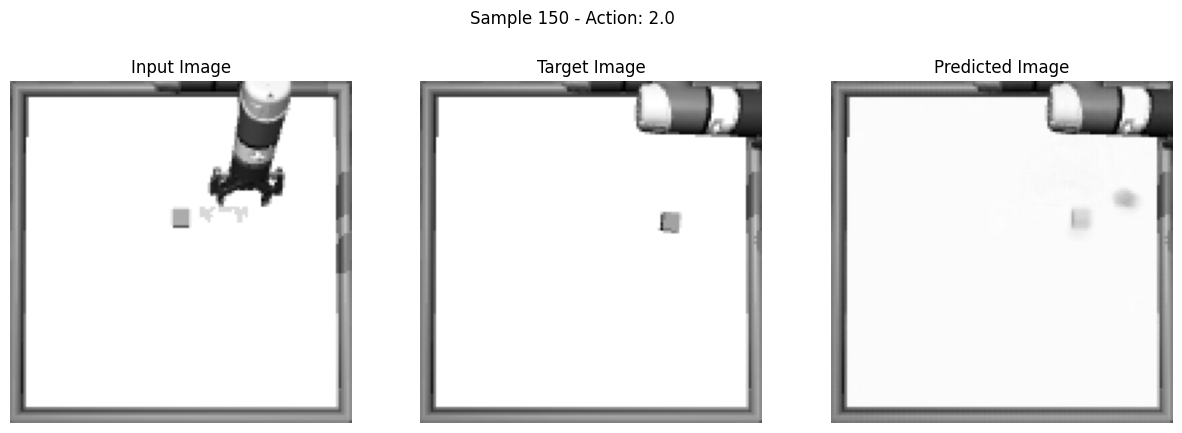

MSE
tensor(0.0003)


In [11]:
# Final validation
totalValLoss = 0

net = net.cpu()

with torch.no_grad():
    net.eval()  # Set the model in evaluation mode
    for j in range(200):
        inputs1 = img_test[j].cpu().unsqueeze(0)  # Add batch dimension
        inputs2 = act_test[j].cpu()
        inputs2_onehot = F.one_hot(inputs2.cpu().to(torch.int64), num_classes=4).float()

        pred = net(inputs1, inputs2_onehot)
        totalValLoss += criterion(pred, after_img_test[j].unsqueeze(0))
                # Display every 50th image
        if j % 50 == 0:
            # Convert tensors to numpy arrays
            input_img = inputs1.squeeze().cpu().numpy()
            target_img = after_img_test[j].squeeze().cpu().numpy()
            pred_img = pred.squeeze().cpu().numpy()

            # Create a figure with three subplots
            plt.figure(figsize=(15, 5))

            # Display input image
            plt.subplot(131)
            plt.imshow(input_img, cmap='gray')
            plt.title('Input Image')
            plt.axis('off')

            # Display target image
            plt.subplot(132)
            plt.imshow(target_img, cmap='gray')
            plt.title('Target Image')
            plt.axis('off')

            # Display predicted image
            plt.subplot(133)
            plt.imshow(pred_img, cmap='gray')
            plt.title('Predicted Image')
            plt.axis('off')

            plt.suptitle(f'Sample {j} - Action: {inputs2.item()}')
            plt.show()


print("MSE")
print(totalValLoss/200)

# Save model
torch.save({
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'final_mse_loss': totalValLoss/200,
}, 'final_model_unet.pth')